# Regression with degree 2 with NLL(Training : Mean, Var) and MSE

In [1]:
%%capture
try:
    from probml_utils import savefig, latexify,is_latexify_enabled
except ModuleNotFoundError :
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify,is_latexify_enabled

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import numpy as np
import os

In [3]:
class MLP(nn.Module):

    def __init__(self, inputs=1, outputs=1, hidden_layers=[101], activation='relu'):
        super(MLP, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        self.hidden_layers = hidden_layers
        self.nLayers = len(hidden_layers)
        self.net_structure = [inputs, *hidden_layers, outputs]
        
        if activation == 'relu':
            self.act = torch.relu
        elif activation == 'tanh':
            self.act = torch.tanh
        elif activation == 'sigmoid':
            self.act = torch.sigmoid
        else:
            print('Activation function not in list')


        for i in range(self.nLayers + 1):
            setattr(self, 'layer_'+str(i), nn.Linear(self.net_structure[i], self.net_structure[i+1]))

    def forward(self, x):

        for i in range(self.nLayers):
            layer = getattr(self, 'layer_'+str(i))
            x = self.act(layer(x))
        layer = getattr(self, 'layer_' + str(self.nLayers))
        x = layer(x)
        return x

In [4]:
class MeanVarModel(MLP):
    def __init__(self, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(MeanVarModel, self).__init__(inputs=inputs, outputs=2*outputs, hidden_layers=hidden_layers, activation=activation)
        self.inputs = inputs
        self.outputs = outputs
    def forward(self, x):
        # connect layers
        for i in range(self.nLayers):
            layer = getattr(self, 'layer_'+str(i))
            x = self.act(layer(x))
        layer = getattr(self, 'layer_' + str(self.nLayers))
        x = layer(x)
        mean, variance = torch.split(x, self.outputs, dim=1)
        variance = F.softplus(variance) 
        return mean, variance

In [5]:
class EnsembleMLP(nn.Module):
 
        #models no. of models , inputs  no. of inputs ,  outputs no. of outputs, hidden_layers : hidden layer sizes

    def __init__(self, num_models=5, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(EnsembleMLP, self).__init__()
        self.num_models = num_models
        self.inputs = inputs
        self.outputs = outputs
        self.hidden_layers = hidden_layers
        self.activation = activation
        for i in range(self.num_models):
            model = MeanVarModel(inputs=self.inputs, 
                                outputs=self.outputs, 
                                hidden_layers=self.hidden_layers,
                                activation=self.activation)
            setattr(self, 'model '+str(i), model)
            
    def forward(self, x):

        means = []
        variances = []
        for i in range(self.num_models):
            model = getattr(self, 'model ' + str(i))
            mean, var = model(x)
            means.append(mean)
            variances.append(var)
        means = torch.stack(means)
        mean = means.mean(dim=0)
        variances = torch.stack(variances)
        variance = (variances + means**2).mean(dim=0) - mean**2
        return mean, variance

In [6]:
def NLLloss(y, mean, var):
    pi = torch.acos(torch.zeros(1)).item() * 2
    pi = torch.pi
    #print(pi)
    return (torch.log(var) /2+ (((y - mean)**2)/var)/2+torch.log(torch.Tensor([2*pi]))/2).sum()

In [7]:
def data_set(points=20, xrange=(-4, 4), std=3.,poly=False,hetero=False):
    xx = torch.tensor([[np.random.uniform(*xrange)] for i in range(points)])
    if(poly):
      if(hetero):
        yy = torch.tensor([[x*3*x + x*x*np.random.normal(0, std)] for x in xx])
      else:
        yy = torch.tensor([[x*3*x + np.random.normal(0, std)] for x in xx])
    else:
      if(hetero):
        yy = torch.tensor([[x*3 + x*np.random.normal(0, std)] for x in xx])
      else:
        yy = torch.tensor([[x*3 + np.random.normal(0, std)] for x in xx])
    # yy = torch.tensor([[x*3*x + x*x*np.random.normal(0, std)] for x in xx])
    return xx, yy

In [8]:
def train(n_models,n_epoch,lr):
  losses = []
  output=[]
  for j in range(1,n_models+1):
    mlp = MLP(hidden_layers=[100], activation='relu') 
    mlp_optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)
    mlp_criterion = nn.MSELoss()    
    loss=[]
    for epoch in range(1,n_epoch+1):
        mlp_optimizer.zero_grad()
        mlp_loss = mlp_criterion(yy, mlp(xx))
        mlp_loss.backward()
        mlp_optimizer.step()
        loss.append(mlp_loss.item())
    output.append(mlp(torch.tensor(x).float()).detach().numpy())
    losses.append(loss)
  # print(len(losses))
  return losses,output

In [9]:
epochs = 100
learning_rate = 0.1
n_models=10
x_range_l =4
n_data_points = 500
data_type = 'Homo' 
#'Homo' or 'Hetero'
data_degree =2

In [10]:
import os

In [11]:
os.environ['LATEXIFY']=str(1)
os.environ['FIG_DIR']='/content/'+data_type+'_'+str(data_degree)

saving image to /content/Homo_2/Actual Data
Figure size: [6. 4.]


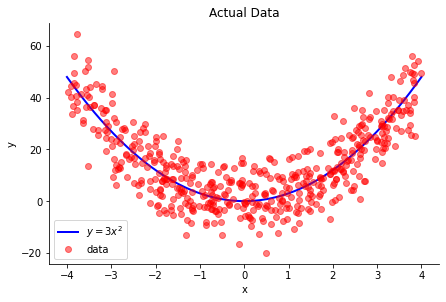

In [12]:
xx, yy = data_set(points=n_data_points, xrange=(-1*x_range_l, 1*x_range_l), std=8.,poly=True,hetero=False) 
x = np.linspace(-1*x_range_l, 1*x_range_l, n_data_points).reshape(n_data_points, 1)
y = 3*x*x
plt.plot(x, y, 'b-', label='$y=3x^{}$'.format(data_degree),linewidth=2)
plt.plot(xx.numpy(),yy.numpy(),'or', label='data',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Actual Data')
sns.despine()
# plt.ylim([-50,100])
savefig('Actual Data')

In [13]:

losses,output =train(n_models,epochs,learning_rate)

In [14]:
output_df = pd.DataFrame(np.array(output).reshape(n_models,500))


saving image to /content/Homo_2/Loss Convergence : Ensemble 1
Figure size: [6. 4.]


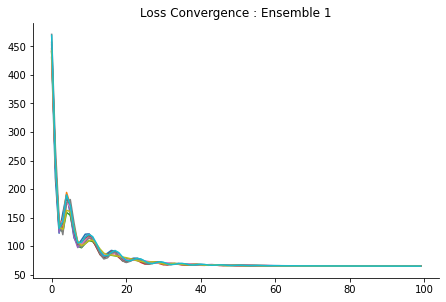

In [15]:
for i in range(n_models):
  plt.plot(np.arange(0,epochs,1),losses[i])

# plt.plot(np.arange(0,epochs,1),losses[1])
plt.title('Loss Convergence : Ensemble 1')
sns.despine()
savefig('Loss Convergence : Ensemble 1')


saving image to /content/Homo_2/Ensemble : 1 output neuron zoom
Figure size: [6. 4.]


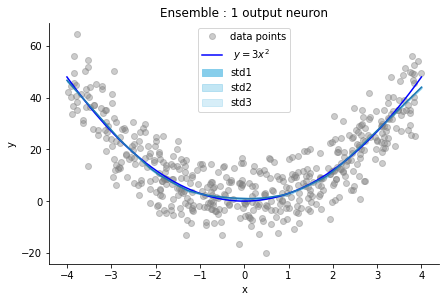

In [16]:
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points',color='grey',alpha=0.4)
plt.plot(x, y, 'b', label=' $y=3x^2$')
mean = output_df.mean()
std=output_df.std()
for i_std in range(1,4):
  plt.fill_between(x.reshape(500,), np.array((mean-i_std*std)).reshape(500,), np.array((mean+i_std*std)).reshape(500,), color='skyblue',alpha=1/i_std, label='std'+str(i_std))
plt.plot(x,output_df.mean())
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ensemble : 1 output neuron')
# plt.ylim([-20,-10])

plt.legend()
sns.despine()
savefig('Ensemble : 1 output neuron zoom')

saving image to /content/Homo_2/Ensemble : 1 output neuron
Figure size: [6. 4.]


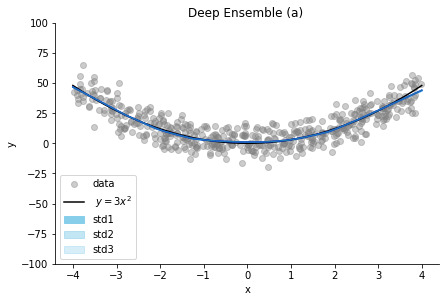

In [17]:
fig, ax = plt.subplots()
ax.plot(xx.numpy(),yy.numpy(),'or', label='data',color='grey',alpha=0.4)
ax.plot(x, y, 'b', label=' $y=3x^2$',color='black')
mean = output_df.mean()
std=output_df.std()
for i_std in range(1,4):
  ax.fill_between(x.reshape(500,), np.array((mean-i_std*std)).reshape(500,), np.array((mean+i_std*std)).reshape(500,), color='skyblue',alpha=1/i_std, label='std'+str(i_std))
ax.plot(x,output_df.mean(),color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deep Ensemble (a) ')
#plt.ylim([-5,10])
plt.plot(x,output_df.mean())
plt.legend('off')
plt.legend()
sns.despine()
plt.ylim([-100,100])
savefig('Ensemble : 1 output neuron')

In [18]:
mlp = MLP(hidden_layers=[100], activation='relu') 
mlp_optimizer = torch.optim.Adam(params=mlp.parameters(), lr=learning_rate)
mlp_criterion = nn.MSELoss()

In [19]:
loss=[]
for epoch in range(epochs):
    mlp_optimizer.zero_grad()
    mlp_loss = mlp_criterion(yy, mlp(xx))
    loss.append(mlp_loss.item())
    mlp_loss.backward()
    mlp_optimizer.step()
    
print('final loss: ',mlp_loss.item())

final loss:  64.6465072631836


saving image to /content/Homo_2/Loss Convergence : Vanilla Model
Figure size: [6. 4.]


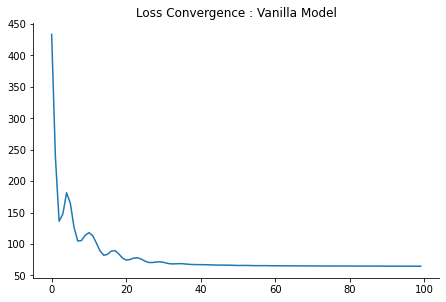

In [20]:

plt.plot(np.arange(0,epochs,1),loss)
plt.title('Loss Convergence : Vanilla Model')
sns.despine()
savefig('Loss Convergence : Vanilla Model')

saving image to /content/Homo_2/Vanilla model
Figure size: [6. 4.]


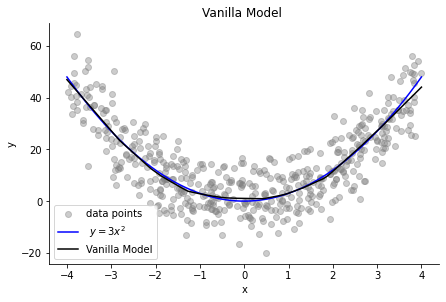

In [21]:
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points',color='grey',alpha=0.4)
plt.plot(x, y, 'b', label=' $y=3x^2$')
plt.plot(x, mlp(torch.tensor(x).float()).detach().numpy(), label='Vanilla Model', color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Vanilla Model ')
plt.legend()
sns.despine()
savefig('Vanilla model')

In [22]:
def train_torch_step(ensemble, optimizer, x, y):

    optimizer.zero_grad()
    mean, var = ensemble(x)
    loss = NLLloss(y, mean, var)
    loss.backward()
    optimizer.step()
    return loss.item()

In [23]:
def train(ensemble, opt, x, y):
    losses = []
    for i in range(ensemble.num_models):
        model = getattr(ensemble, 'model ' + str(i))
        loss = train_torch_step(ensemble, opt[i], x, y)
        losses.append(loss)
    return losses

In [24]:
ensemble = EnsembleMLP(num_models=n_models, hidden_layers=[100])
opt = []
for i in range(ensemble.num_models):
    model = getattr(ensemble, 'model ' + str(i))
    opt.append(torch.optim.Adam(params=model.parameters(), lr=learning_rate))

In [25]:
loss_ensemble=[]
for epoch in range(epochs):
    losses = train(ensemble, opt, xx, yy)
    loss_ensemble.append(losses)
    print(losses)

[74126.8671875, 10531.171875, 7017.6142578125, 6174.4599609375, 4858.1923828125, 4069.30810546875, 3585.921630859375, 3414.407470703125, 3180.466552734375, 3042.34765625]
[2931.13232421875, 2638.27490234375, 2515.6123046875, 2406.059814453125, 2277.686767578125, 2170.50927734375, 2150.718505859375, 2128.2578125, 2100.393798828125, 2069.88720703125]
[2066.561767578125, 2042.0728759765625, 2042.8175048828125, 2022.6324462890625, 2004.3656005859375, 1990.3106689453125, 1996.17529296875, 1990.389892578125, 1986.694091796875, 1980.536865234375]
[1978.6044921875, 1977.4281005859375, 1986.837890625, 1986.37158203125, 1987.9139404296875, 1993.8028564453125, 1997.48095703125, 1996.5782470703125, 1998.22314453125, 1999.8447265625]
[1996.47021484375, 1999.0379638671875, 2006.4971923828125, 2010.6646728515625, 2016.40283203125, 2024.70556640625, 2025.3267822265625, 2025.98291015625, 2027.373291015625, 2030.2166748046875]
[2027.2896728515625, 2030.5555419921875, 2035.443115234375, 2039.63623046875,

In [31]:
x_plot=  np.linspace(-15, 15, n_data_points).reshape(n_data_points, 1)

In [32]:



mean, var = ensemble(torch.tensor(x_plot).float())
mean = mean.detach().numpy()
var = var.detach().numpy()
std = np.sqrt(var)

saving image to /content/Homo_2/Ensemble 2
Figure size: [6. 4.]


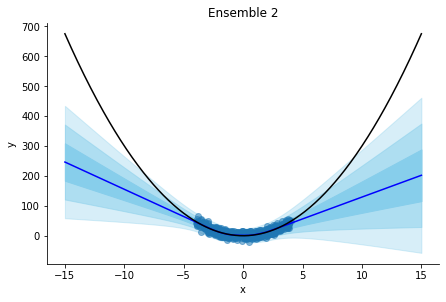

In [33]:
for i_std in range(1,4):
  plt.fill_between(x_plot.reshape(500,), (mean-i_std*std).reshape(500,), (mean+i_std*std).reshape(500,), color='skyblue',alpha=1/i_std, label='std'+str(i_std))
plt.plot(x_plot, mean, label='Mean',color='blue')
plt.plot(x_plot, 3*x_plot*x_plot, 'b', label='y=3x',color='black')
plt.scatter(xx.numpy(),yy.numpy(), label='data',alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ensemble 2')
# plt.legend(loc='lower center')
sns.despine()
# plt.xlim([-8,8])
# plt.ylim([-100,100])
savefig('Ensemble 2')

saving image to /content/Homo_2/Loss Convergence : Ensemle 2
Figure size: [6. 4.]


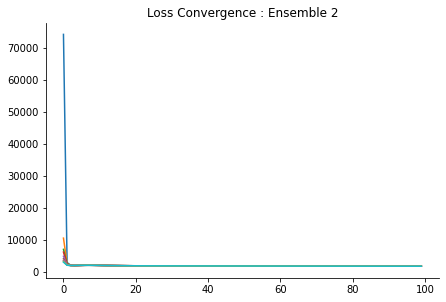

In [29]:
# Few Models Initial Loss shoots up a lot
plt.plot(np.arange(0,epochs,1),loss_ensemble)
# plt.xlim([0,100])
sns.despine()
plt.title('Loss Convergence : Ensemble 2'.format(n_models))
savefig('Loss Convergence : Ensemle 2')

saving image to /content/Homo_2/Loss Convergence : Ensemle 2
Figure size: [6. 4.]


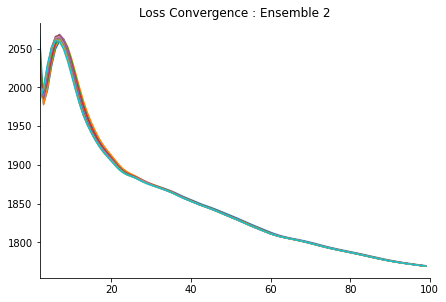

In [30]:
plt.plot(np.arange(2,epochs,1),loss_ensemble[2:])
plt.xlim([2,100])
sns.despine()
plt.title('Loss Convergence : Ensemble 2'.format(n_models))
savefig('Loss Convergence : Ensemle 2')